# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install --upgrade albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple


# Download Dataset

> original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


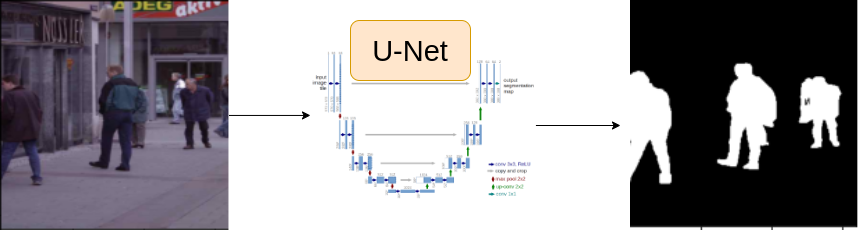

# Some Common Imports

In [3]:
import sys
sys.path.append('Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2
from torchsummary import summary as torchsumm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task 2 : Setup Configurations

In [5]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = ''

DEVICE = 'cuda'

EPOCHS = 50
LR = 0.003

IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

SEED = 35

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
idx = 4
row = df.iloc[idx]

img_path = row.images
mask_path = row.masks

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

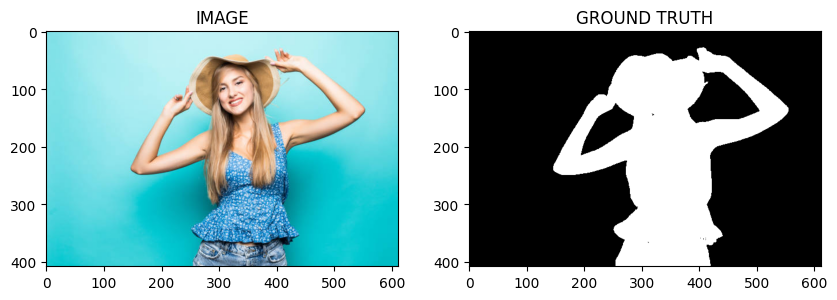

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = SEED)

# Task 3 : Augmentation Functions

> `albumentation` documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as alb

In [11]:
def get_train_augs():
    return alb.Compose([
        alb.Resize(IMG_SIZE, IMG_SIZE),
        alb.HorizontalFlip(p = 0.5),
        alb.VerticalFlip(p = 0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return alb.Compose([
        alb.Resize(IMG_SIZE, IMG_SIZE),
    ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row.images
        mask_path = row.masks

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (hgt, wgt, chl) => (chl, hgt, wgt)

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


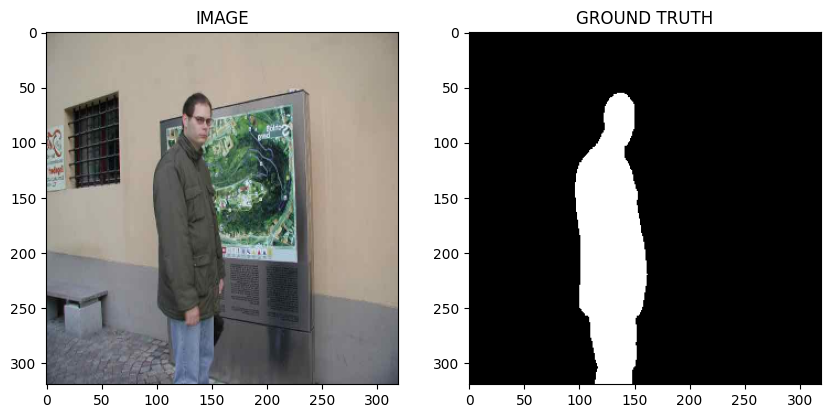

In [16]:
idx = 5

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'Total number of batches in train loader: {len(trainloader)}')
print(f'Total number of batches in valid loader: {len(validloader)}')

Total number of batches in train loader: 15
Total number of batches in valid loader: 4


In [20]:
for image, mask in trainloader:
    break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

> `segmentation_models_pytorch` documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arch = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits = self.arch(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)
torchsumm(model, input_size=(3, 320, 320), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             864
          Identity-2         [-1, 32, 160, 160]               0
             Swish-3         [-1, 32, 160, 160]               0
    BatchNormAct2d-4         [-1, 32, 160, 160]              64
            Conv2d-5         [-1, 32, 160, 160]             288
          Identity-6         [-1, 32, 160, 160]               0
             Swish-7         [-1, 32, 160, 160]               0
    BatchNormAct2d-8         [-1, 32, 160, 160]              64
            Conv2d-9              [-1, 8, 1, 1]             264
            Swish-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 160, 160]               0
           Conv2d-14         [-1, 16, 1

/opt/conda/lib/python3.10/site-packages/torchsummary/torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [25]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_valid_loss = np.Inf
losses = []

for epoch in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    losses.append({'epoch': epoch, 'train': train_loss, 'valid': valid_loss})

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print("Saved Model")
        best_valid_loss = valid_loss

    print(f"Epoch = {epoch+1} | Train loss : {train_loss} | Valid loss {valid_loss}")

100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


Saved Model
Epoch = 1 | Train loss : 0.7611144800980886 | Valid loss 0.8675712570548058


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Saved Model
Epoch = 2 | Train loss : 0.40598656932512917 | Valid loss 0.394540399312973


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Saved Model
Epoch = 3 | Train loss : 0.28465850055217745 | Valid loss 0.3123250864446163


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Saved Model
Epoch = 4 | Train loss : 0.24324897229671477 | Valid loss 0.18477553874254227


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Saved Model
Epoch = 5 | Train loss : 0.2543114344278971 | Valid loss 0.15399363450706005


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Epoch = 6 | Train loss : 0.20021861791610718 | Valid loss 0.22068318724632263


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Epoch = 7 | Train loss : 0.2374870439370473 | Valid loss 0.20321454107761383


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Epoch = 8 | Train loss : 0.20453757643699647 | Valid loss 0.20012027584016323


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Saved Model
Epoch = 9 | Train loss : 0.1585349977016449 | Valid loss 0.14855702221393585


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Epoch = 10 | Train loss : 0.16458178361256917 | Valid loss 0.15584206953644753


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Epoch = 11 | Train loss : 0.1907487784822782 | Valid loss 0.21406696364283562


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Epoch = 12 | Train loss : 0.1562428280711174 | Valid loss 0.20235487818717957


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Epoch = 13 | Train loss : 0.19302625159422557 | Valid loss 0.22289546951651573


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Epoch = 14 | Train loss : 0.2536630094051361 | Valid loss 0.3094988353550434


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Epoch = 15 | Train loss : 0.2189290742079417 | Valid loss 0.23936912417411804


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Epoch = 16 | Train loss : 0.16119158466657002 | Valid loss 0.1831851489841938


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Saved Model
Epoch = 17 | Train loss : 0.15513437539339064 | Valid loss 0.14754927903413773


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Epoch = 18 | Train loss : 0.17132192403078078 | Valid loss 0.15847941115498543


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Epoch = 19 | Train loss : 0.16197720964749654 | Valid loss 0.15620772168040276


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Epoch = 20 | Train loss : 0.13517028838396072 | Valid loss 0.1633845679461956


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Saved Model
Epoch = 21 | Train loss : 0.1409916639328003 | Valid loss 0.14222915843129158


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Epoch = 22 | Train loss : 0.1224403997262319 | Valid loss 0.1577061079442501


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Epoch = 23 | Train loss : 0.1571947087844213 | Valid loss 0.17364612594246864


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Epoch = 24 | Train loss : 0.13566971570253372 | Valid loss 0.1625385768711567


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Epoch = 25 | Train loss : 0.13619531492392223 | Valid loss 0.15057129226624966


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Epoch = 26 | Train loss : 0.11315572957197825 | Valid loss 0.168965520337224


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Epoch = 27 | Train loss : 0.11836832910776138 | Valid loss 0.1657287199050188


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Saved Model
Epoch = 28 | Train loss : 0.1129191999634107 | Valid loss 0.13290220499038696


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Saved Model
Epoch = 29 | Train loss : 0.10419277399778366 | Valid loss 0.1279948391020298


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Epoch = 30 | Train loss : 0.10958348711331685 | Valid loss 0.1366377118974924


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Epoch = 31 | Train loss : 0.09686982134977977 | Valid loss 0.13736432045698166


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Epoch = 32 | Train loss : 0.10104006975889206 | Valid loss 0.15933793410658836


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Epoch = 33 | Train loss : 0.10177608529726664 | Valid loss 0.15669499710202217


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Epoch = 34 | Train loss : 0.09309838463862737 | Valid loss 0.1522516142576933


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch = 35 | Train loss : 0.10267077833414077 | Valid loss 0.21030272357165813


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Epoch = 36 | Train loss : 0.10091531574726105 | Valid loss 0.14627236872911453


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Saved Model
Epoch = 37 | Train loss : 0.08183174878358841 | Valid loss 0.12167520634829998


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Saved Model
Epoch = 38 | Train loss : 0.0813312699397405 | Valid loss 0.11208572424948215


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


Epoch = 39 | Train loss : 0.07606270983815193 | Valid loss 0.12889661267399788


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Epoch = 40 | Train loss : 0.07367804795503616 | Valid loss 0.11999950185418129


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Epoch = 41 | Train loss : 0.06668336316943169 | Valid loss 0.11569805257022381


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Saved Model
Epoch = 42 | Train loss : 0.06469009518623352 | Valid loss 0.11206641793251038


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Saved Model
Epoch = 43 | Train loss : 0.06090105101466179 | Valid loss 0.10827340185642242


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Epoch = 44 | Train loss : 0.06320046111941338 | Valid loss 0.1117922905832529


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Epoch = 45 | Train loss : 0.062205414722363156 | Valid loss 0.11330384202301502


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Epoch = 46 | Train loss : 0.06133128975828488 | Valid loss 0.16349179297685623


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Epoch = 47 | Train loss : 0.06615346943338712 | Valid loss 0.13978254050016403


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Epoch = 48 | Train loss : 0.07063456252217293 | Valid loss 0.13838580809533596


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Epoch = 49 | Train loss : 0.10005333920319875 | Valid loss 0.13339246436953545


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]

Epoch = 50 | Train loss : 0.08350692441066106 | Valid loss 0.13469927199184895


# Task 9 : Inference

In [29]:
idx = 8

model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask>0.5)*1.0

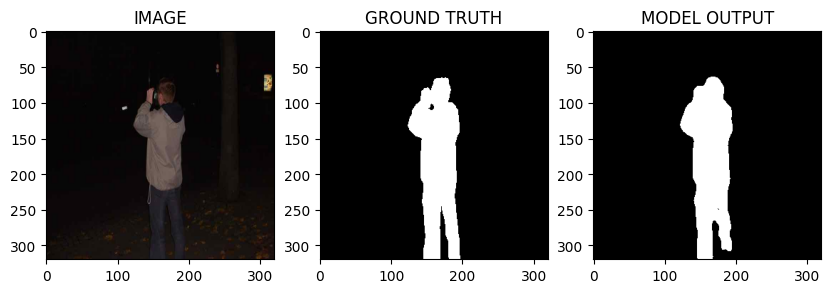

In [30]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

<Axes: xlabel='epoch'>

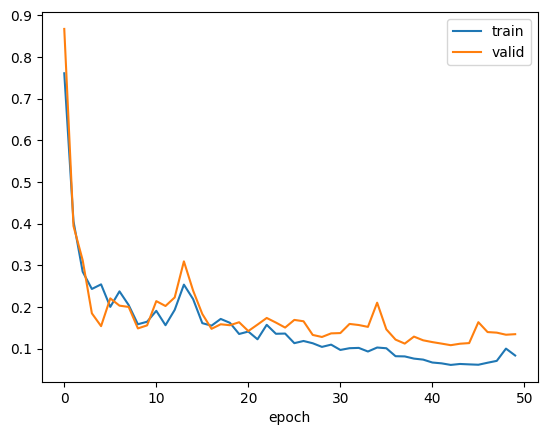

In [31]:
pd.DataFrame(losses).set_index('epoch').plot(kind='line')

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya